In [43]:
import argparse
import json
import os
import pandas as pd
from pprint import pprint
import numpy as np
from vega import VegaLite

# default directories
OUTPUT_DIR = os.path.join("output")

# arguments
parser = argparse.ArgumentParser()
parser.add_argument(dest="log_dir")

def parse_log_content(lines):

    status = {
        "num_candidates": [],
        "table_prog": None,
        "vis_spec": None,
        "time": -0.1
    }

    for i, l in enumerate(lines):
        if l.startswith("# candidates before getting the correct solution: "):
            status["num_candidates"].append(int(l.split(":")[-1].strip()))
        if l.startswith("# time used (s): "):
            status["time"] = float(l.split(":")[-1].strip())
        if l.startswith("# table_prog:") and len(lines) > i + 1:
            status["table_prog"] = lines[i + 1]
        if l.startswith("# vis_spec:") and len(lines) > i + 1:
            status["vis_spec"] = lines[i + 1]
    status["solved"] = status["time"] !=  -0.1
    return status

def analyze(log_dir):
    all_result = []
    for fname in os.listdir(log_dir):
        if not fname.endswith(".log"): continue
        fpath = os.path.join(log_dir, fname)
        with open(fpath) as f:
            status = parse_log_content(f.readlines())
            status["data_id"] = fname.split(".")[0]
            status["num_explored"] = sum(status["num_candidates"])
            status.pop("num_candidates")
            status.pop("vis_spec")
            status.pop("table_prog")
            all_result.append(status)
    
    plot_data = []
    for i in np.linspace(0, max([x["time"] for x in all_result if x["time"] is not None]), 1000):
        cnt = 0
        for r in all_result:
            if r["time"] > 0 and r["time"] < i:
                cnt += 1
        plot_data.append({"time": i, "cnt": cnt})
    
    df = pd.DataFrame.from_dict(all_result)
    cdf = pd.DataFrame.from_dict(plot_data)
    
    chart = {
        "width": 800,
        "autosize": {
            "type": "fit",
            "contains": "padding"
          },
        "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
        "mark": {"type": "bar"},
        "encoding": {
            "y": {"field": "time", "type": "quantitative"},
            "x": { "field": "data_id", "type": "nominal" },
            "color": {"field": "solved", "type": "nominal"}
        }
    }
    
    chart2 = {
        "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
        "mark": {"type": "line"},
        "encoding": {
            "y": {"field": "cnt", "type": "quantitative"},
            "x": { "field": "time", "type": "quantitative" }
        }
    }
    
    chart3 = {
        "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
        "mark": {"type": "bar"},
        "encoding": {
            "y": {"field": "num_explored", "type": "quantitative"},
            "x": { "field": "data_id", "type": "quantitative" }
        }
    }
    
    VegaLite(chart, df).display()
    VegaLite(chart2, cdf).display()
    VegaLite(chart3, df).display()

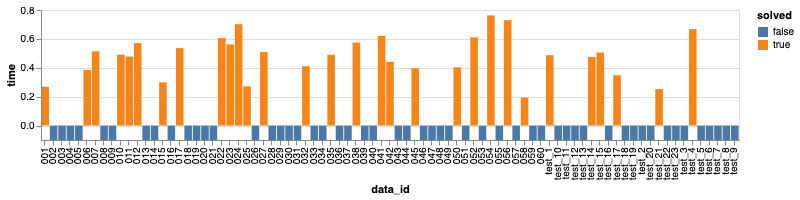

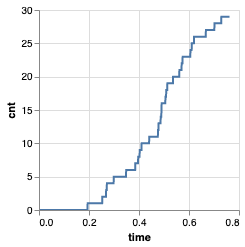

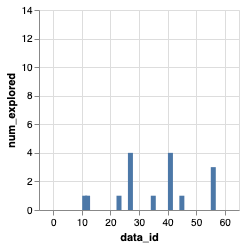

In [44]:
analyze("exp_20190706_164344")